### Cvičení 1

1. Do proměnné `df` načtěte data se srážkami z GitHub.
2. Omezte `df` na sloupce `DATE`, `NAME`, `PRCP`.
3. Do proměnné `df_py` vytvořte kopii proměnné `df`.
4. Vytvořte sloupec `df_py['DATE_PY']`, ve kterém bude offset `df_py['DATE']` o 1 rok.
5. Spojte `df` a `df_py`.
6. Dopočítejte sloupce `ROK`, `MESIC` ze sloupce `DATE`.

7. Vytvořte ipywidgets typu dropdown pro sloupce `NAME`, `ROK`.

8. Vytvořte grid o rozměrech 2x2, kdy:
    - Na prvním řádku bude graf napříč oběma sloupci:
        - Osa x: měsíc.
        - Osa y: Suma srážek v daném roce, měsíci, name.
        - Osa y: Suma srážek v předchozím roce, daném měsíci a name.
    - Na druhém řádku, první graf (tj. graf zabere 1 sloupec, tento graf nebude filtrován na rok vybraný uživatelem, ale pouze na name):
        - Osa x: rok.
        - Osa y: Suma srážek v daném roce, name.
        - Osa y2: Průměrné roční srážky v dané name.
    - Na druhém řádku, druhý graf (tj. graf zabere 1 sloupec, tento graf bude filtrován rokem i name vybraným uživatelem):
        - Osa x: měsíc.
        - Osa y: Kumulativní suma srážek v daném roce, name.



In [3]:
import pandas as pd
import ipywidgets as widgets
from matplotlib import pyplot as plt



# Načtení dat
df = pd.read_csv('https://raw.githubusercontent.com/petrrozkosny/pydata/main/pydata_data.csv', delimiter=';')

df = df[['DATE','NAME','PRCP']]
df['DATE'] = pd.to_datetime(df['DATE'])

df_py = df.copy()
df_py['DATE_PY'] = df_py['DATE'] - pd.DateOffset(years=1)

df = df.merge(df_py[['DATE_PY','NAME','PRCP']], left_on=['DATE','NAME'], right_on=['DATE_PY','NAME'], how='left', suffixes=('', '_PREDCHOZI'))
df['ROK'] = df['DATE'].dt.year
df['MESIC'] = df['DATE'].dt.month

list_name = widgets.Dropdown(options=df['NAME'].unique(), description='Název:', disabled=False)
list_rok  = widgets.Dropdown(options=sorted(df['ROK'].unique()), description='Rok:', disabled=False)


output = widgets.Output()

def zmena(change):

    global df
    
    fig = plt.figure(figsize=(20,6))
    grid = (2,2)
    # Nastavení velikosti jednotlivých axes ve fig
    graf1 = plt.subplot2grid(grid,(0,0),rowspan=1,colspan=2)
    graf2 = plt.subplot2grid(grid,(1,0),rowspan=1,colspan=1)
    graf3 = plt.subplot2grid(grid,(1,1),rowspan=1,colspan=1)

    df1 = df
    rok = list_rok.value
    name = list_name.value
    df1 = df1[(df1['ROK'] == rok) & (df1['NAME'] == name)]
    df1 = df1.groupby('MESIC').agg({'PRCP':'sum', 'PRCP_PREDCHOZI':'sum'}).reset_index()

    df2 = df.copy()
    df2 = df2[df2['NAME'] == name]
    df2 = df2.groupby('ROK').agg({'PRCP':'sum'}).reset_index()
    df2_prumer = df2['PRCP'].mean()

    df3 = df.copy()
    df3 = df3[(df3['NAME'] == name) & (df3['ROK'] == rok)]
    df3 = df3.groupby(['MESIC']).agg({'PRCP':'sum'}).reset_index()
    df3_kumulace = df3['PRCP'].cumsum()

    with output:
        output.clear_output()
        graf1.plot(df1['MESIC'], df1['PRCP'], label='Aktuální rok')
        graf1.plot(df1['MESIC'], df1['PRCP_PREDCHOZI'], linestyle='dashed',label='Předchozí rok')
        graf1.legend(loc='upper right')

        graf2.plot(df2['ROK'], df2['PRCP'], label='Celkové srážky')
        graf2.axhline(y=df2_prumer, color='r', linestyle='--', label='Průměr')
        
        graf3.plot(df3['MESIC'], df3_kumulace, label='Kumulace srážek')


        graf1.set_title('Srážky v roce {}'.format(rok))
        graf1.set_xlabel('Měsíc')
        graf1.set_ylabel('Srážky [mm]')
        graf1.set_xticks(df1['MESIC'])
        graf1.set_xticklabels(df1['MESIC'])

        graf2.set_title('Celkové srážky v letech')
        graf2.set_xlabel('Rok')
        graf2.set_ylabel('Srážky [mm]')
        graf2.set_xticks(df2['ROK'])
        graf2.legend()

        graf3.set_title('Kumulace srážek v roce {}'.format(rok))
        graf3.set_xlabel('Měsíc')
        graf3.set_ylabel('Kumulace srážek [mm]')
        graf3.set_xticks(df3['MESIC'])
        graf3.set_xticklabels(df3['MESIC'])
        plt.show()
        

list_name.observe(zmena, names='value')
list_rok.observe(zmena, names='value')

display(list_name, list_rok,output)



Dropdown(description='Název:', options=('PIDING', 'PRAHA KLEMENTINUM', 'RUZYNE', 'KOSICE', 'MOSNOV', 'PRAHA LI…

Dropdown(description='Rok:', options=(2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, …

Output()

Dropdown(description='Název:', options=('GRAZ', 'KOSICE', 'MOSNOV', 'PIDING', 'PRAHA KLEMENTINUM', 'PRAHA LIBU…

Output()

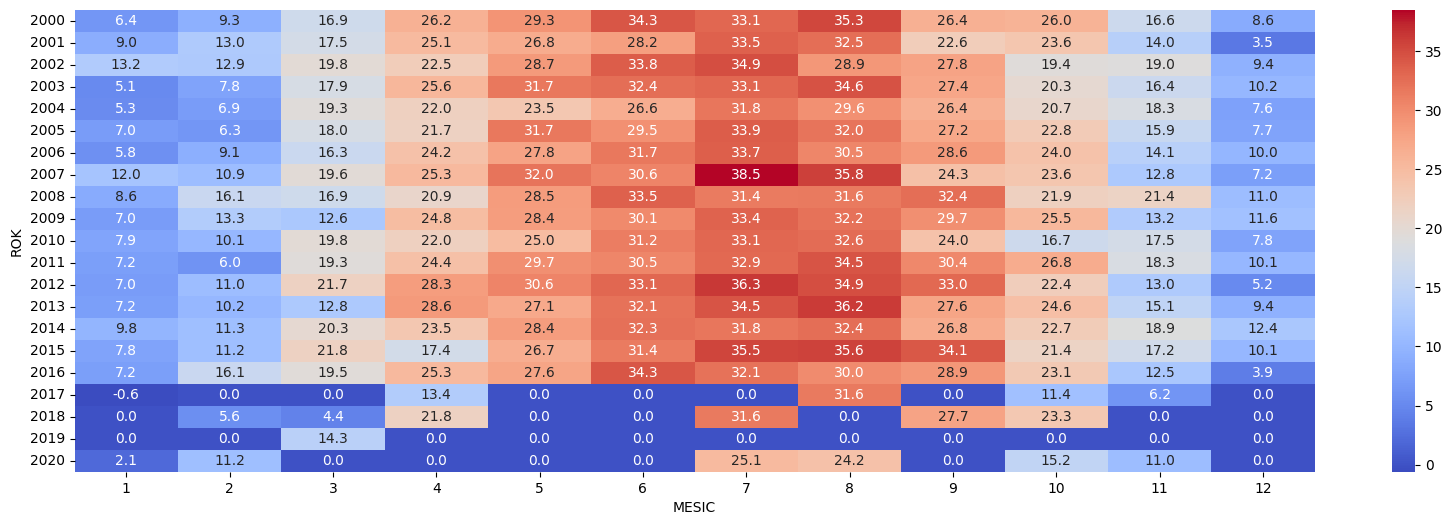

In [2]:
import pandas as pd
import ipywidgets as widgets
from matplotlib import pyplot as plt
import seaborn as sns



# Načtení dat
df = pd.read_csv('https://raw.githubusercontent.com/petrrozkosny/pydata/main/pydata_data.csv', delimiter=';')


df['DATE'] = pd.to_datetime(df['DATE'])

df['ROK'] = df['DATE'].dt.year
df['MESIC'] = df['DATE'].dt.month
df = df[['NAME','ROK','MESIC','TMAX']]

df = pd.pivot_table(df, values='TMAX', index=['NAME','ROK'], columns='MESIC', aggfunc='max', fill_value=0)

output = widgets.Output()



def aktualizuj_tabulku(change):

    fig = plt.figure(figsize=(20,6))    
    with output:
        output.clear_output()
        df1 = df.copy()
        df1 = df1.loc[df1.index.get_level_values(0) == list_name.value]
        df1 = df1.droplevel(0)
        heatmap = sns.heatmap(df1, annot=True, fmt=".1f", cmap='coolwarm')
       


list_name = widgets.Dropdown(options=df.index.get_level_values(0).unique(), description='Název:', disabled=False)
list_name.observe(aktualizuj_tabulku, names='value')

display(list_name, output)


### Cvičení 2

1. Do proměnné `df` načtěte data se srážkami z GitHub.
2. Omezte `df` na sloupce `DATE`, `NAME`, `TMAX`.
3. Dopočítejte sloupce `ROK`, `MESIC` ze sloupce `DATE`.
4. Pivotujte `df` tak, aby měl tvar:
    - Index: `name`, `rok`
    - Sloupce: `mesic`
    - Hodnoty: maximum z `TMAX`.

5. Vytvořte ipywidgets dropdown s unikátními `NAME`.

6. Po výběru / aktualizaci výběru zobrazte uživateli `sns.heatmap` (viz [seaborn.heatmap](https://seaborn.pydata.org/generated/seaborn.heatmap.html))
   Tabulka na výstupu bude mít podobu:
   - Index: `ROK`
   - Sloupce: `MESIC`
   - Hodnoty: maximum z `TMAX`
   
   Pozn.: Výše uvedené máte spočítáno, stačí se zbavit indexu `NAME`.
